In [7]:
import json
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Faulty engine", 'Fixed by', 'WC', "Code Size"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    checkmark = "\\checkmark" if metadata['wrong-code'] else ""
    table_data.append([
        test_name,
        metadata['engine'],
        metadata['fixed-by'],
        checkmark,
        data['metadata']['code-size'],
        # metadata['function_count']
    ])
# Sort the table data by the original size code
table_data.sort(key=lambda row: row[4] if isinstance(row[4], (int, float)) else float('inf'))

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, intfmt=",", tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")

# Save the table to a file
print(f"Number of eval set: {len(table_data)}")
rq1_table_path = f'./table/eval_set.tex'
with open(rq1_table_path, 'w') as file:
    print(latex_table)
    file.write(latex_table)
    print(f"Table saved to {rq1_table_path}")

Number of eval set: 28
\begin{tabular}{llllr}
\hline
 Name            & Faulty engine   & Fixed by   & WC         &   Code Size \\
\hline
 wasmedge\#3018   & WasmEdge        & 93fd4ae    & \checkmark &       1,913 \\
 wamr\#2789       & WAMR            & 718f06     &            &      17,604 \\
 wasmedge\#3019   & WasmEdge        & 93fd4ae    & \checkmark &      19,098 \\
 wamr\#2862       & WAMR            & 0ee5ff     & \checkmark &      19,727 \\
 wamr\#2450       & WAMR            & e360b7     &            &      24,482 \\
 wasmedge\#3076   & WasmEdge        & 93fd4ae    & \checkmark &      31,365 \\
 mandelbrot      & Wizard          & 0b43b8     & \checkmark &      64,515 \\
 pathfinding     & Wizard          & ccf0c56    & \checkmark &     180,026 \\
 pacalc          & Wizard          & 81555ab    & \checkmark &     238,902 \\
 wasmedge\#3057   & WasmEdge        & 93fd4ae    & \checkmark &     243,564 \\
 guiicons        & Wizard          & 6d2b057    & \checkmark &     285,840 

In [2]:
import json
import tabulate
from scipy.stats import gmean

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input", "W-S", "RR-R (Target)", "W-R", "H-R"]

# size_to_use = 'module-size'
size_to_use = 'code-size'

wasm_shrink_code_size_percentages = []
rr_reduce_code_size_percentages = []
rr_reduce_target_size_percentages = []
wasm_reduce_code_size_percentages = []
wasm_hybrid_code_size_percentages = []

def guard_000(value):
    if value < 0.01:
        return "\\textless{}0.01%"
    return f"{value:.2f}%"

lowest_tool = {}
for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        fixed_by = metadata.get('fixed-by')
        wrong_code = metadata.get('wrong-code')
        original_code_size = data['metadata'].get(size_to_use)
        wasm_shrink_code_size = data['wasm-shrink'].get('code-size')
        rr_reduce_code_size = data['wasm-slice'].get('code-size')
        rr_reduce_target_size = data['wasm-slice'].get('target-size')
        wasm_hybrid_all_code_size = data['wasm-hybrid'].get(size_to_use)
        wasm_reduce_code_size = data['wasm-reduce'].get(size_to_use)

        wasm_shrink_code_size_percentage = (wasm_shrink_code_size / original_code_size) * 100
        rr_reduce_code_size_percentage = (rr_reduce_code_size / original_code_size) * 100
        rr_reduce_target_size_percentage = (rr_reduce_target_size / original_code_size) * 100
        wasm_reduce_code_size_percentage = (wasm_reduce_code_size / original_code_size) * 100
        wasm_hybrid_code_size_percentage = (wasm_hybrid_all_code_size / original_code_size) * 100

        # Push percentages to their respective lists
        wasm_shrink_code_size_percentages.append(wasm_shrink_code_size_percentage)
        rr_reduce_code_size_percentages.append(rr_reduce_code_size_percentage)
        rr_reduce_target_size_percentages.append(rr_reduce_target_size_percentage)
        wasm_hybrid_code_size_percentages.append(wasm_hybrid_code_size_percentage)
        wasm_reduce_code_size_percentages.append(wasm_reduce_code_size_percentage)
        # Determine the tool with the lowest code size percentage
        min_percentage = min(wasm_shrink_code_size_percentage, rr_reduce_code_size_percentage, wasm_reduce_code_size_percentage, wasm_hybrid_code_size_percentage)
        lowest_tools = []
        if min_percentage == wasm_shrink_code_size_percentage:
            lowest_tools.append('W-S')
        if min_percentage == rr_reduce_code_size_percentage:
            lowest_tools.append('RR-R (Target)')
        if min_percentage == wasm_reduce_code_size_percentage:
            lowest_tools.append('W-R')
        if min_percentage == wasm_hybrid_code_size_percentage:
            lowest_tools.append('H-R')
        lowest_tool[test_name] = ', '.join(lowest_tools)

        table_data.append([
            test_name,
            original_code_size,
            guard_000(wasm_shrink_code_size_percentage),
            f"{guard_000(rr_reduce_code_size_percentage)} ({guard_000(rr_reduce_target_size_percentage)})",
            guard_000(wasm_reduce_code_size_percentage),
            guard_000(wasm_hybrid_code_size_percentage)
        ])
    except Exception as e:
        print(test_name, data)
        print(e)
        continue
# Sort the table data by the original size
table_data.sort(key=lambda row: float(row[1]))

# Calculate geometric mean for the percentages
geomean_wasm_shrink = gmean(wasm_shrink_code_size_percentages)
geomean_rr_reduce = gmean(rr_reduce_code_size_percentages)
geomean_rr_reduce_target = gmean(rr_reduce_target_size_percentages)
geomean_wasm_reduce = gmean(wasm_reduce_code_size_percentages)
geomean_wasm_hybrid_all = gmean(wasm_hybrid_code_size_percentages)

# Append the geometric mean row
table_data.append([
    "Geomean",
    "",
    f"{geomean_wasm_shrink:.2f}%",
    f"{geomean_rr_reduce:.2f}% ({geomean_rr_reduce_target:.2f}%)",
    f"{geomean_wasm_reduce:.2f}%",
    f"{geomean_wasm_hybrid_all:.2f}%"
])

# Add geometric mean to lowest_tool
lowest_tool["Geomean"] = "H-R"

# Make the lowest tool bold in the table
for row in table_data:
    test_name = row[0]
    if test_name in lowest_tool:
        tools = lowest_tool[test_name]
        for tool in tools.split(', '):
            tool_index = headers.index(tool)
            row[tool_index] = f"\\textbf{{{row[tool_index]}}}"

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=".2f")

# Escape percentage signs in the LaTeX table
latex_table = latex_table.replace('%', '\\%')

rq2_table_path = f'./table/rq1.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

\begin{tabular}{llllll}
\hline
 Name            & Input   & W-S            & RR-R (Target)            & W-R                       & H-R                       \\
\hline
 wasmedge#3018   & 1913    & 4.65\%          & 23.73\% (17.09\%)          & 1.25\%                     & \textbf{0.58\%}            \\
 wamr#2789       & 17604   & \textbf{0.05\%} & 2.33\% (0.59\%)            & \textbf{0.05\%}            & \textbf{0.05\%}            \\
 wasmedge#3019   & 19098   & 7.71\%          & 3.75\% (0.92\%)            & \textbf{0.06\%}            & \textbf{0.06\%}            \\
 wamr#2862       & 19727   & 2.95\%          & 9.27\% (7.12\%)            & \textbf{0.18\%}            & \textbf{0.18\%}            \\
 wamr#2450       & 24482   & 11.48\%         & 3.33\% (1.73\%)            & \textbf{0.03\%}            & \textbf{0.03\%}            \\
 wasmedge#3076   & 31365   & 27.33\%         & 2.81\% (0.33\%)            & 0.04\%                     & \textbf{0.04\%}            \\
 mandelbrot      & 645

In [ ]:
import json
from scipy.stats import gmean
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "W-S (s)","W-R (s)", "H-R (s)", "RR-R (s)", 'T']

# Sort the metrics dictionary by the 'code-size' in the 'metadata' field
metrics = dict(sorted(metrics.items(), key=lambda item: item[1]['metadata'].get('code-size', float('inf'))))

for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        # fixed_by = metadata.get('fixed-by')
        # original_size = data['metadata'].get('code-size')
        rr_reduce_time = float(data['wasm-slice'].get('time'))
        wasm_hybrid_all_time = float(data['wasm-hybrid'].get('time'))
        wasm_reduce_time = float(data['wasm-reduce'].get('time'))
        wasm_shrink_time = float(data['wasm-shrink'].get('time'))
        target_kind = data['wasm-slice']['target-kind']
        if target_kind == 'all':
            target_kind = 'A'
        elif target_kind == 'heuristic':
            target_kind = 'H'
        elif target_kind == 'dynamic':
            target_kind = 'D'
        else:
            raise ValueError(f"Unexpected target-kind: {target_kind}")
        table_data.append([
            test_name,
            # fixed_by,
            # original_size,
            wasm_shrink_time,
            wasm_reduce_time,
            wasm_hybrid_all_time,
            rr_reduce_time,
            target_kind
        ])
    except Exception as e:
        print(e)
        continue

from statistics import mean
# Calculate arithmetic mean for the times
mean_wasm_shrink_time = mean([row[1] for row in table_data])
mean_wasm_reduce_time = mean([row[2] for row in table_data])
mean_wasm_hybrid_time = mean([row[3] for row in table_data])
mean_rr_reduce_time = mean([row[4] for row in table_data])

# Append the geometric mean row
table_data.append([
    "Mean",
    mean_wasm_shrink_time,
    mean_wasm_reduce_time,
    mean_wasm_hybrid_time,
    mean_rr_reduce_time
])

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=",.0f")

rq2_table_path = f'./table/rq2.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

\begin{tabular}{lrrrrl}
\hline
 Name            &   W-S (s) &   W-R (s) &   H-R (s) &   RR-R (s) & T   \\
\hline
 wasmedge#3018   &       129 &        23 &        52 &         25 & A   \\
 wamr#2789       &        24 &         6 &     1,210 &      1,200 & A   \\
 wasmedge#3019   &        10 &     4,195 &        56 &         30 & A   \\
 wamr#2862       &       300 &        54 &       188 &        137 & A   \\
 wamr#2450       &        35 &        31 &        59 &         45 & A   \\
 wasmedge#3076   &    86,400 &     1,017 &       799 &        783 & A   \\
 mandelbrot      &    15,178 &    86,400 &    73,482 &        236 & H   \\
 pathfinding     &     3,722 &     3,627 &     1,155 &        965 & D   \\
 pacalc          &       616 &     1,014 &    21,424 &         16 & D   \\
 wasmedge#3057   &    86,400 &     2,599 &     1,965 &      2,034 & A   \\
 guiicons        &     1,285 &    29,266 &    20,458 &         75 & H   \\
 rtexviewer      &       774 &       197 &       640 &        

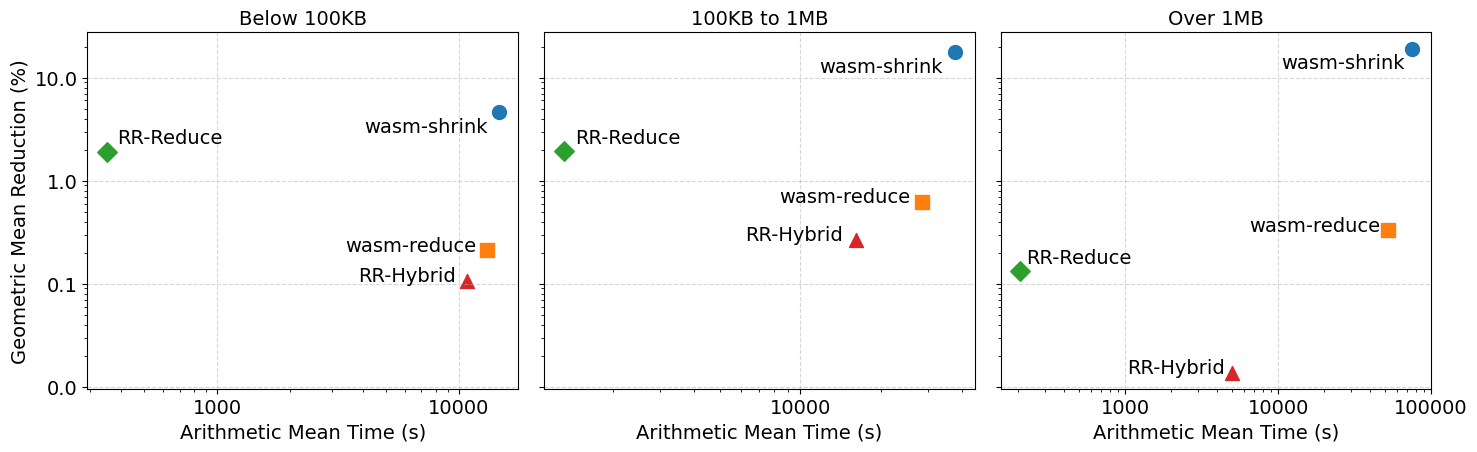

In [38]:
import json
from statistics import mean
from scipy.stats import gmean
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib import rcParams

# Set global font sizes
rcParams.update({
    'font.size': 14,           # Base font size
    'axes.titlesize': 14,      # Subplot titles
    'axes.labelsize': 14,      # Axis labels
    'xtick.labelsize': 14,     # X tick labels
    'ytick.labelsize': 14,     # Y tick labels
    'legend.fontsize': 14,     # Legend font size (if used)
    'figure.titlesize': 14     # Main title (suptitle)
})

# Load metrics from JSON
with open("metrics.json") as f:
    data = json.load(f)

# Group inputs by code size
grouped_data = {
    "Below 100KB": [],
    "100KB to 1MB": [],
    "Over 1MB": []
}

for key, value in data.items():
    code_size = value.get("metadata", {}).get("code-size", 0)
    if code_size < 100_000:
        grouped_data["Below 100KB"].append((key, value))
    elif code_size < 1_000_000:
        grouped_data["100KB to 1MB"].append((key, value))
    else:
        grouped_data["Over 1MB"].append((key, value))

# Prepare aggregated results for plotting
aggregated_results = {}

for group, items in grouped_data.items():
    reductions = {'wasm-shrink': [], 'wasm-reduce': [], 'wasm-slice': [], 'wasm-hybrid': []}
    times = {'wasm-shrink': [], 'wasm-reduce': [], 'wasm-slice': [], 'wasm-hybrid': []}

    for key, value in items:
        for tool, tool_data in value.items():
            if tool == "metadata":
                continue
            input_size = value["metadata"]["code-size"]
            # reduced_size = tool_data["code-size"]
            reduced_size = tool_data["target-size"] if tool == "wasm-slice" else tool_data["code-size"]

            time = tool_data["time"]
            if input_size > 0 and reduced_size > 0:
                reduction = (reduced_size / input_size) * 100
                reductions[tool].append(reduction)
            if time > 0:
                times[tool].append(time)

    aggregated_results[group] = {}
    for tool in reductions:
        if reductions[tool] and times[tool]:
            aggregated_results[group][tool] = (
                mean(times[tool]),
                gmean(reductions[tool])
            )

# Plotting
tool_labels = {
    "wasm-shrink": "wasm-shrink",
    "wasm-reduce": "wasm-reduce",
    "wasm-slice": "RR-Reduce",
    "wasm-hybrid": "RR-Hybrid"
}
tools = list(tool_labels.keys())
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
markers = ["o", "s", "D", "^"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
group_names = list(aggregated_results.keys())

for idx, group in enumerate(group_names):
    ax = axes[idx]
    for i, tool in enumerate(tools):
        if tool in aggregated_results[group]:
            time, reduction = aggregated_results[group][tool]
            ax.scatter(time, reduction, color=colors[i], marker=markers[i], s=100, label=tool_labels[tool])
            # Place RR-Reduce label top right, others top left
            if tool_labels[tool] == "RR-Reduce":
                ax.text(time * 1.1, reduction * 1.1, tool_labels[tool],
                        fontsize=14, ha='left', va='bottom')
            elif tool_labels[tool] == "wasm-shrink":
                ax.text(time * 0.9, reduction * 0.9, tool_labels[tool],
                        fontsize=14, ha='right', va='top')
            else:
                ax.text(time * 0.9, reduction * 0.9, tool_labels[tool],
                        fontsize=14, ha='right', va='bottom')
    ax.set_title(group)
    ax.set_xlabel("Arithmetic Mean Time (s)")
    if idx == 0:
        ax.set_ylabel("Geometric Mean Reduction (%)")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='x')
    ax.ticklabel_format(style='plain', axis='y')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/Users/<anom>/Desktop/rr-reduce-paper/ase_2025/figures/tradeoff.pdf", format="pdf", bbox_inches="tight")